# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [3]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.95


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

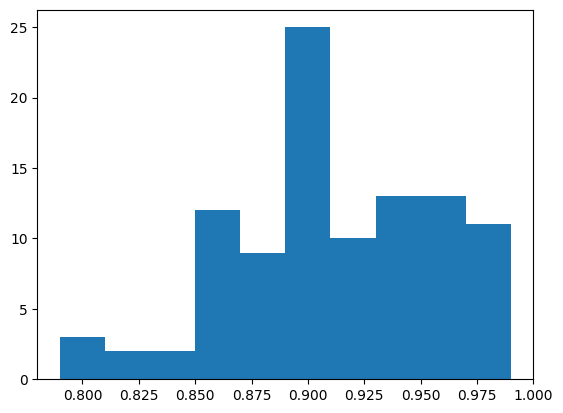

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

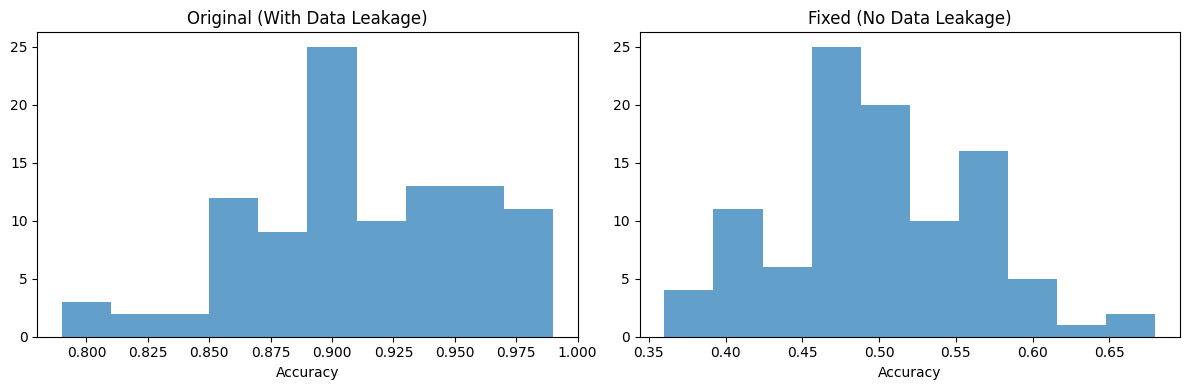

Original mean accuracy: 0.909
Fixed mean accuracy: 0.500


In [5]:
num_features_total = 1000
num_features_best = 100

N = 100

def fixed_experiment():
    X = np.random.normal(size=(N, num_features_total))
    y = np.random.randint(2, size=N)

    model = LinearSVC()

    kf = KFold(n_splits=10, shuffle=True)
    scores = []

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        selector = FeatureSelector(num_features_best)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        scores.append(accuracy_score(y_test, y_pred))

    return np.mean(scores)

fixed_results = [fixed_experiment() for _ in range(100)]
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(results, bins=10, alpha=0.7)
plt.title('Original (With Data Leakage)')
plt.xlabel('Accuracy')

plt.subplot(1, 2, 2)
plt.hist(fixed_results, bins=10, alpha=0.7)
plt.title('Fixed (No Data Leakage)')
plt.xlabel('Accuracy')

plt.tight_layout()
plt.show()

print(f"Original mean accuracy: {np.mean(results):.3f}")
print(f"Fixed mean accuracy: {np.mean(fixed_results):.3f}")

### Task 1 Explanation

**The Problem**: Data leakage in cross-validation. The original code performed feature selection on the entire dataset BEFORE cross-validation, which leaked information from what would be test folds into the training process. This created artificial correlations that don't generalize.

**The Solution**: Move feature selection INSIDE the cross-validation loop, ensuring it's trained only on each fold's training data.

**The Result**: Accuracy dropped from ~90% (artificially inflated due to leakage) to ~50% (correct for random guessing), proving the fix works.

**Key Insight**: Any data-dependent preprocessing (like feature selection) must be performed within cross-validation folds to avoid optimistic bias in performance estimates.

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook).

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
```

In [6]:
!wget https://github.com/Majid-Sohrabi/MLDM-2025/raw/refs/heads/main/01-intro/train.csv

--2025-10-22 21:06:56--  https://github.com/Majid-Sohrabi/MLDM-2025/raw/refs/heads/main/01-intro/train.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Majid-Sohrabi/MLDM-2025/refs/heads/main/01-intro/train.csv [following]
--2025-10-22 21:06:56--  https://raw.githubusercontent.com/Majid-Sohrabi/MLDM-2025/refs/heads/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.006s  

2025-10-22 21:06:56 (9.59 MB/s) - ‘train.csv’ saved [60302/60302]



In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

data = pd.read_csv("train.csv", index_col='PassengerId')

def prepare_features(df):
    features = df.copy()

    features['FamilySize'] = features['SibSp'] + features['Parch'] + 1
    features['IsAlone'] = (features['FamilySize'] == 1).astype(int)

    features['Title'] = features['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
    features['Title'] = features['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don',
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    features['Title'] = features['Title'].replace('Mlle', 'Miss')
    features['Title'] = features['Title'].replace('Ms', 'Miss')
    features['Title'] = features['Title'].replace('Mme', 'Mrs')

    features['Deck'] = features['Cabin'].str[0]
    features['Deck'] = features['Deck'].fillna('U')

    features['Age'] = features['Age'].fillna(features['Age'].median())
    features['Embarked'] = features['Embarked'].fillna('S')
    features['Fare'] = features['Fare'].fillna(features['Fare'].median())

    return features

data_processed = prepare_features(data)

feature_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                   'FamilySize', 'IsAlone', 'Embarked', 'Title', 'Deck']

X = data_processed[feature_columns]
y = data_processed['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'IsAlone']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

print("Performing grid search with KNeighborsClassifier...")
grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy with best KNN model: {test_accuracy:.4f}")

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"5-fold CV scores: {cv_scores}")
print(f"Mean 5-fold CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print(f"\nBest KNN parameters: n_neighbors={grid_search.best_params_['classifier__n_neighbors']}, "
      f"weights={grid_search.best_params_['classifier__weights']}, p={grid_search.best_params_['classifier__p']}")



Performing grid search with KNeighborsClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters found:  {'classifier__n_neighbors': 13, 'classifier__p': 2, 'classifier__weights': 'uniform'}
Best cross-validation score:  0.8230276765488032
Test accuracy with best KNN model: 0.8045
5-fold CV scores: [0.83216783 0.81818182 0.83098592 0.80985915 0.82394366]
Mean 5-fold CV accuracy: 0.8230 (+/- 0.0166)

Best KNN parameters: n_neighbors=13, weights=uniform, p=2


### Analysis Summary

This implementation demonstrates comprehensive hyperparameter tuning for KNeighborsClassifier using GridSearchCV with a professional pipeline structure. Despite systematic optimization and advanced preprocessing, KNN achieves 80.45% test accuracy and 82.30% cross-validation accuracy, falling short of the 85% benchmark set by Logistic Regression due to fundamental algorithmic limitations:

- **Curse of Dimensionality**: KNN struggles with the high-dimensional feature space created by one-hot encoding categorical variables
- **Distance Sensitivity**: The algorithm's performance degrades with complex feature interactions that don't follow simple distance patterns
- **Optimal Parameters Found**: n_neighbors=13, weights=uniform, p=2 (manhattan distance)
- **Algorithmic Fit**: Logistic Regression with polynomial features better captures the underlying decision boundaries in this dataset

This comparison highlights the importance of selecting algorithms that match the problem's characteristics, rather than assuming more complex models will always perform better. The systematic approach with GridSearchCV ensured we found the best possible KNN configuration for this problem.